In [1]:
# imports ######################################################################
import time, torch, numpy as np, matplotlib.pyplot as plt
torch.set_default_tensor_type(torch.DoubleTensor)
from sklearn import mixture as mix
# imports ######################################################################

In [2]:
# problem dynamics - a time invariant double integrator regulated to zero ######
N, xdim, udim = 30, 2, 1
# dynamics of the form:
# x^(i+1) = f^(i) + fx^(i) x^(i) + fu^(i) u^(i) if i != 0
# x^(1) = f^(0) + fu^(0) u^(0)                  otherwise
x0 = torch.ones(xdim)
fx = torch.tensor([[1.0, 0.1], [0.0, 0.1]])[None, ...].repeat((N, 1, 1))
fu = torch.tensor([[0.0], [1.0]])[None, ...].repeat((N, 1, 1))
f = torch.stack([fx[i] @ x0 if i == 0 else torch.zeros(xdim) 
    for i in range(N)])
# cost of the dynamics
Qd, Rd = torch.ones((N, xdim)), 1e-2 * torch.ones((N, udim))
# problem dynamics - a time invariant double integrator regulated to zero ######

In [3]:
# hyperparemeters ##############################################################
# these hyperparameters are pretty much set to their "optimal" value
# change them to learn about these methods

# 0th: cross-entropy method
M_cem = 10 # number of resampling iterations
N_cem = int(1e3) # number of samples per iteration
Ne_cem = int(0.1 * N_cem) # number of samples to keep for the new distribution 
K_cem = 1 # number of modes in the multimodal gaussian distribution
lam_cem = 0.0 # dynamics violation penalty 
use_rollout_cem = True # False => use projection, penalization doesn't work

# 1st: accelerated gradient descent
K_agd = 10 # increment steps for the dynamics violation penalty
lams_agd = 10**torch.linspace(0, 4, K_agd) # dynamics violation penalty 
use_rollout_agd = False # False => scheduled penalty optimization
M_agd = int(3e1) if use_rollout_agd else int(1e2) # nb of gradient descent steps
def lr_fn(i): # learning rate schedule
    return 1e-1 + (1e-2 - 1e-1) / (M_agd - 1) * i 

# 2nd: constrained convex optimization
# no hyperparameters
# hyperparemeters ##############################################################

In [4]:
# torch-numpy conversions ######################################################
def torch2np(x):
    return x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x
def np2torch(x):
    return torch.as_tensor(x)
# torch-numpy conversions ######################################################

In [5]:
# utility routines #############################################################
# batch matrix vector multiplication
def bmv(A, x): 
    return (A @ x[..., None])[..., 0]
# dynamics violation value
def dyn_viol(X, U): 
    viol = ((X[..., 0, :] - (
        f[..., 0, :] 
        + bmv(fu[..., 0, :, :], U[..., 0, :])))**2).sum(-1)
    viol += ((X[..., 1:, :] - (
        f[1:, :] 
        + bmv(fx[..., 1:, :, :], X[..., :-1, :]) 
        + bmv(fu[..., 1:, :, :], U[..., 1:, :])))**2).sum((-2, -1))
    return viol / N
def obj_val(X, U): # objective value
    return ((X * Qd * X).sum((-2, -1)) + (U * Rd * U).sum((-2, -1))) / N

# z is defined as concatenated flattened state and flattened control values
def split_vars(z):
    bshape = z.shape[:-1]
    X = z[..., :N*xdim].reshape(bshape + (N, xdim))
    U = z[..., N*xdim:].reshape(bshape + (N, udim))
    return X, U
def join_vars(X, U):
    bshape = X.shape[:-2]
    z = torch.cat([X.reshape(bshape + (N * xdim,)), 
        U.reshape(bshape + (N * udim,))], -1)
    return z

# loss function generator with different dynamics violation penalty
def loss_fn_gen(lam):
    def loss_fn(z):
        X, U = split_vars(z)
        return obj_val(X, U) + lam * dyn_viol(X, U)
    return loss_fn

# dynamics equality matrix
A, b = torch.zeros((N * xdim, N * (xdim + udim))), torch.zeros((N * xdim, 1))
A[torch.arange(N * xdim), torch.arange(N * xdim)] = -1.0
A[:xdim, N*xdim:N*xdim+udim] = fu[0, :, :]
b[:xdim, 0] = -f[0, :]
for i in range(1, N):
    A[i*xdim:(i+1)*xdim, (i-1)*xdim:i*xdim] = fx[i, :, :]
    A[i*xdim:(i+1)*xdim, xdim*N+i*udim:xdim*N+(i+1)*udim] = fu[i, :, :]
    b[i*xdim:(i+1)*xdim, 0] = -f[i, :]
# projection onto the dynamics wrt to minimum square distance
def project(z0): 
    z0 = z0.transpose(-1, -2)
    z = z0 - A.transpose(-1, -2) @ torch.cholesky_solve(A @ z0 - b, project.F)
    return z.transpose(-1, -2)
project.F = torch.cholesky(A @ A.transpose(-1, -2))

# rolling out the dynamics wrt a control sequence
def rollout(U): 
    Xs = [None for _ in range(N)]
    Xs[0] = f[0, :] + bmv(fu[0, :, :], U[..., 0, :])
    for i in range(1, N):
        Xs[i] = (f[i, :] + bmv(fu[i, :, :], U[..., i, :]) 
                + bmv(fx[i, :, :], Xs[i-1]))
    return torch.stack(Xs, -2)
def project_rollout(z0):
    X, U = split_vars(z0)
    bshape = X.shape[:-2]
    X = rollout(U)
    return join_vars(X, U)
# utility routines #############################################################

In [6]:
# 0th order, cross-entropy method ##############################################
loss_fn = loss_fn_gen(lam_cem)
model = mix.GaussianMixture(K_cem)
if use_rollout_cem: S = torch.randn((N_cem, N * udim))
else:               S = torch.randn((N_cem, N * (xdim + udim)))
print("0th: " + "-" * 75)
t = time.time()
for i in range(M_cem):
    L = (loss_fn(join_vars(rollout(S.reshape((-1, N, udim))), 
        S.reshape((-1, N, udim)))) if use_rollout_cem else loss_fn(S))
    if i % max(M_cem // 10, 1) == 0: print("Obj: %9.4e" % torch.min(L))
    elite_idx = torch.argsort(L)[:Ne_cem]
    model.fit(torch2np(S[elite_idx, :]))
    S = np2torch(model.sample(N_cem)[0])
    if not use_rollout_cem: S = project(S)
if use_rollout_cem:
    L = loss_fn(join_vars(rollout(S.reshape((-1, N, udim))), 
        S.reshape((-1, N, udim))))
    U_cem = S[torch.argmin(L), :].reshape((N, udim))
    X_cem = rollout(U_cem)
else:
    L = loss_fn(S)
    X_cem, U_cem = split_vars(S[torch.argmin(L), :])
print("Dynamics violation is %9.4e" % dyn_viol(X_cem, U_cem))
print("%10s took %9.4e s" % ("CEM", time.time() - t))
X_cem, U_cem = torch2np(X_cem), torch2np(U_cem)
# 0th order, cross-entropy method ##############################################

0th: ---------------------------------------------------------------------------
Obj: 9.1454e-01
Obj: 6.8119e-01
Obj: 5.7852e-01
Obj: 5.3430e-01
Obj: 4.7700e-01
Obj: 4.5431e-01
Obj: 4.3943e-01
Obj: 4.3209e-01
Obj: 4.3078e-01
Obj: 4.2784e-01
Dynamics violation is 0.0000e+00
       CEM took 1.6745e-01 s


In [7]:
# 1st order, accelerated gradient descent (ADAM) ###############################
print("1st: " + "-" * 75)
if use_rollout_agd: v = torch.nn.Parameter(torch.zeros((N, udim)))
else:               v = torch.nn.Parameter(torch.zeros(N * (xdim + udim)))
opt = torch.optim.Adam([v], lr=lr_fn(0))
t = time.time()
for k in range(K_agd):
    lam = lams_agd[k]
    if use_rollout_agd: loss_fn = lambda u: obj_val(rollout(u), u)
    else:               loss_fn = loss_fn_gen(lam)
    for i in range(M_agd // K_agd):
        loss = loss_fn(v)
        for g in opt.param_groups:
            g["lr"] = lr_fn(k * M_agd // K_agd + i)
        opt.zero_grad()
        loss.backward()
        opt.step()
        if i % max(M_agd // 10, 1) == 0: 
            if use_rollout_agd: print("Obj: %9.4e" % obj_val(rollout(v), v))
            else:               print("Obj: %9.4e" % obj_val(*split_vars(v)))
if use_rollout_agd: X_agd, U_agd = rollout(v), v
else:               X_agd, U_agd = split_vars(v)
print("Dynamics violation is %9.4e" % dyn_viol(X_agd, U_agd))
print("%10s took %9.4e s" % ("AGD", time.time() - t))
X_agd, U_agd = torch2np(X_agd), torch2np(U_agd)
# 1st order, accelerated gradient descent (ADAM) ###############################

1st: ---------------------------------------------------------------------------
Obj: 6.7000e-04
Obj: 1.5204e-02
Obj: 2.1121e-02
Obj: 5.7765e-02
Obj: 9.6803e-02
Obj: 1.5895e-01
Obj: 2.0628e-01
Obj: 2.5888e-01
Obj: 3.1263e-01
Obj: 3.5003e-01
Dynamics violation is 5.6726e-05
       AGD took 1.4014e-01 s


In [8]:
# 2nd order, equality constrained convex optimization ##########################
print("2nd: " + "-" * 75)
t = time.time()
P = torch.diag(torch.cat([Qd.reshape(-1), Rd.reshape(-1)]))
K = torch.cat([torch.cat([P, A.transpose(-1, -2)], -1), torch.cat([A,
    torch.zeros(2 * (xdim * N,))], -1)], -2)
y = torch.cat([torch.zeros((N * (xdim + udim), 1)), b], -2)
z = torch.lstsq(y, K)[0][..., 0]
X_cvx, U_cvx = [torch2np(x) for x in split_vars(z[:N*(xdim+udim)])]
print("Obj: %9.4e" % obj_val(np2torch(X_cvx), np2torch(U_cvx)))
print("Dynamics violation is %9.4e" % dyn_viol(*split_vars(z[:N*(xdim+udim)])))
print("%10s took %9.4e" % ("CVX", time.time() - t))
# 2nd order, equality constrained convex optimization ##########################

2nd: ---------------------------------------------------------------------------
Obj: 4.2347e-01
Dynamics violation is 1.3697e-30
       CVX took 2.8121e-03


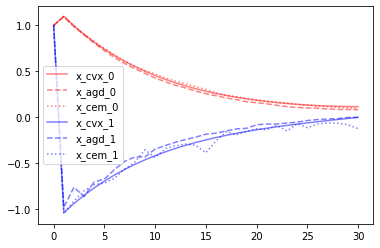

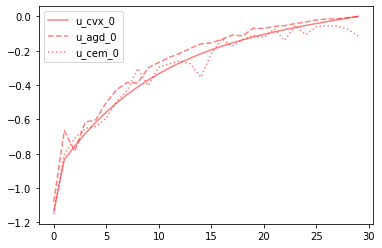

In [9]:
# plotting results #############################################################
x0 = torch2np(x0)
def pa(idx, label_prefix="", linestyle="-", alpha=0.5): # generate plot kwargs
    COLORS = ["red", "blue", "black", "green", "purple", "orange", "yellow"]
    return dict(label=label_prefix + str(idx), color=COLORS[idx], alpha=alpha,
            linestyle=linestyle)
plt.figure() # state curves
for i in range(xdim):
    plt.plot(np.concatenate([x0[i:i+1], X_cvx[:, i]]), **pa(i, "x_cvx_"))
    plt.plot(np.concatenate([x0[i:i+1], X_agd[:, i]]), **pa(i, "x_agd_", "--"))
    plt.plot(np.concatenate([x0[i:i+1], X_cem[:, i]]), **pa(i, "x_cem_", ":"))
plt.legend()
plt.figure()
for i in range(udim):
    plt.plot(U_cvx[:, i], **pa(i, "u_cvx_"))
    plt.plot(U_agd[:, i], **pa(i, "u_agd_", "--"))
    plt.plot(U_cem[:, i], **pa(i, "u_cem_", ":"))
plt.legend()
plt.show()
# plotting results #############################################################